In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['annotation', 'all-dogs']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm_notebook as tqdm
from time import time
from PIL import Image
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import random
from torch.nn.utils import spectral_norm
from scipy.stats import truncnorm
import torch as th

batch_size = 32

In [3]:
start = time()

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples

        self.samples = self._load_subfolders_images(directory)
        if len(self.samples) == 0:
            raise RuntimeError("Found 0 files in subfolders of: {}".format(directory))

    def _load_subfolders_images(self, root):
        IMG_EXTENSIONS = (
        '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        paths = []
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            if is_valid_file(path):
                # Load image
                img = dset.folder.default_loader(path)

                # Get bounding boxes
                annotation_basename = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(
                        dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                        dirname.startswith(annotation_basename.split('_')[0]))
                annotation_filename = os.path.join('../input/annotation/Annotation/',
                                                   annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    
                    w = np.min((xmax - xmin, ymax - ymin))
                    bbox = (xmin, ymin, xmin+w, ymin+w)
                    object_img = required_transforms(img.crop(bbox))
                    #object_img = object_img.resize((64,64), Image.ANTIALIAS)
                    imgs.append(object_img)
        return imgs

    def __getitem__(self, index):
        sample = self.samples[index]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return np.asarray(sample)
    
    def __len__(self):
        return len(self.samples)


In [6]:
%%time
database = '../input/all-dogs/all-dogs/'

transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform,n_samples=25000)


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=batch_size, num_workers = 4)


CPU times: user 1min 19s, sys: 5.55 s, total: 1min 25s
Wall time: 2min 4s


In [7]:
# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

In [8]:
def show_generated_img_all():
    gen_z = torch.randn(32, nz, 1, 1, device=device)
    gen_images = netG(gen_z).to("cpu").clone().detach()
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)
    gen_images = (gen_images+1.0)/2.0
    fig = plt.figure(figsize=(25, 16))
    for ii, img in enumerate(gen_images):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow(img)
    #plt.savefig(filename)  

In [9]:
### This is to show one sample image for iteration of chosing
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    gen_image = ((gen_image+1.0)/2.0)
    plt.imshow(gen_image)
    plt.show()

In [10]:
class MinibatchStdDev(th.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size,1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)
        # return the computed values:
        return y


[1/2000][0/692] Loss_D: 1.3716 Loss_G: 2.3724 D(x): 0.4883 D(G(z)): 0.4829 / 0.0345
[1/2000][500/692] Loss_D: 0.7367 Loss_G: 4.4656 D(x): 0.7024 D(G(z)): 0.0170 / 0.0025



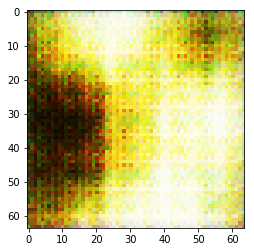

[2/2000][308/692] Loss_D: 0.8711 Loss_G: 2.2805 D(x): 0.4236 D(G(z)): 0.0243 / 0.0522



[3/2000][116/692] Loss_D: 0.7981 Loss_G: 1.9057 D(x): 0.5129 D(G(z)): 0.0585 / 0.0772
[3/2000][616/692] Loss_D: 0.7937 Loss_G: 2.5557 D(x): 0.7091 D(G(z)): 0.1446 / 0.0304



[4/2000][424/692] Loss_D: 0.9443 Loss_G: 2.6707 D(x): 0.6521 D(G(z)): 0.2377 / 0.0253



[5/2000][232/692] Loss_D: 1.1765 Loss_G: 1.5074 D(x): 0.2488 D(G(z)): 0.0328 / 0.1416



[6/2000][40/692] Loss_D: 0.8179 Loss_G: 2.1808 D(x): 0.5364 D(G(z)): 0.0864 / 0.0488
[6/2000][540/692] Loss_D: 0.9084 Loss_G: 2.1695 D(x): 0.6502 D(G(z)): 0.2379 / 0.0524



[7/2000][348/692] Loss_D: 0.8753 Loss_G: 1.3513 D(x): 0.4939 D(G(z)): 0.1205 / 0.1748



[8/2000][156/692] Loss_D: 0.8987 Loss_G: 1.6295 D(x): 0.4766 D(G(z)): 0.1353 / 0.1104
[8/2000][656/692] Loss_D: 0.9277 Loss_G: 1.5422 D(x): 0.4424 D(G(z)): 0.1192 / 0.1281



[9/2000][464/692] Loss_D: 0.9192 Loss_G: 1.4641 D(x): 0.5718 D(G(z)): 0.2127 / 0.1514



[10/2000][272/692] Loss_D: 1.0086 Loss_G: 1.1021 D(x): 0.4498 D(G(z)): 0.1995 / 0.2476



[11/2000][80/692] Loss_D: 1.0786 Loss_G: 1.3462 D(x): 0.3116 D(G(z)): 0.1436 / 0.1719
[11/2000][580/692] Loss_D: 1.0810 Loss_G: 1.5517 D(x): 0.5935 D(G(z)): 0.3237 / 0.1235



[12/2000][388/692] Loss_D: 0.9317 Loss_G: 2.0585 D(x): 0.6020 D(G(z)): 0.1897 / 0.0584



[13/2000][196/692] Loss_D: 1.0815 Loss_G: 1.6848 D(x): 0.7100 D(G(z)): 0.3760 / 0.1009



[14/2000][4/692] Loss_D: 0.9585 Loss_G: 1.2837 D(x): 0.4005 D(G(z)): 0.0989 / 0.1895


In [11]:

class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = spectral_norm(nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False))
        #self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        #self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        #self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = spectral_norm(nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        #self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = spectral_norm(nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False))
        #self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = spectral_norm(nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False))
        # state size. (nchannels) x 64 x 64
        self.pixnorm = PixelwiseNorm()
    def forward(self, x):
        #x = F.leaky_relu(self.bn1(self.conv1(x)))
        #x = F.leaky_relu(self.bn2(self.conv2(x)))
        #x = F.leaky_relu(self.bn3(self.conv3(x)))
        #x = F.leaky_relu(self.bn4(self.conv4(x)))
        #x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.pixnorm(x)
        x = torch.tanh(self.conv6(x))
        
        return x



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        
        self.conv2 = spectral_norm(nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = spectral_norm(nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv4 = spectral_norm(nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)
        # state size. (nfeats*8) x 4 x 4
        self.batch_discriminator = MinibatchStdDev()
        self.pixnorm = PixelwiseNorm()
        self.conv5 = spectral_norm(nn.Conv2d(nfeats * 8 +1, 1, 2, 1, 0, bias=False))
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
       # x = self.pixnorm(x)
        x = self.batch_discriminator(x)
        x = torch.sigmoid(self.conv5(x))
        #x= self.conv5(x)
        return x.view(-1, 1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0003
lr_d = 0.0001
beta1 = 0.5
#epochs = 1600 # final
epochs = 2000  # test; just for check
netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()
#criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_d, betas=(beta1, 0.999))
lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG,
                                                                     T_0=epochs//200, eta_min=0.00005)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD,
                                                                     T_0=epochs//200, eta_min=0.00005)

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.7
fake_label = 0.0
batch_size = train_loader.batch_size



### training here


step = 0
for epoch in range(epochs):
    for ii, (real_images) in tqdm(enumerate(train_loader), total=len(train_loader)):
        end = time()
        if (end -start) > 25000 :
            break
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device) +  np.random.uniform(-0.1, 0.1)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label) + np.random.uniform(0, 0.2)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)

    if epoch % 200 == 0:
        show_generated_img()
        
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')

def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 100
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, 100, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)    
    #gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

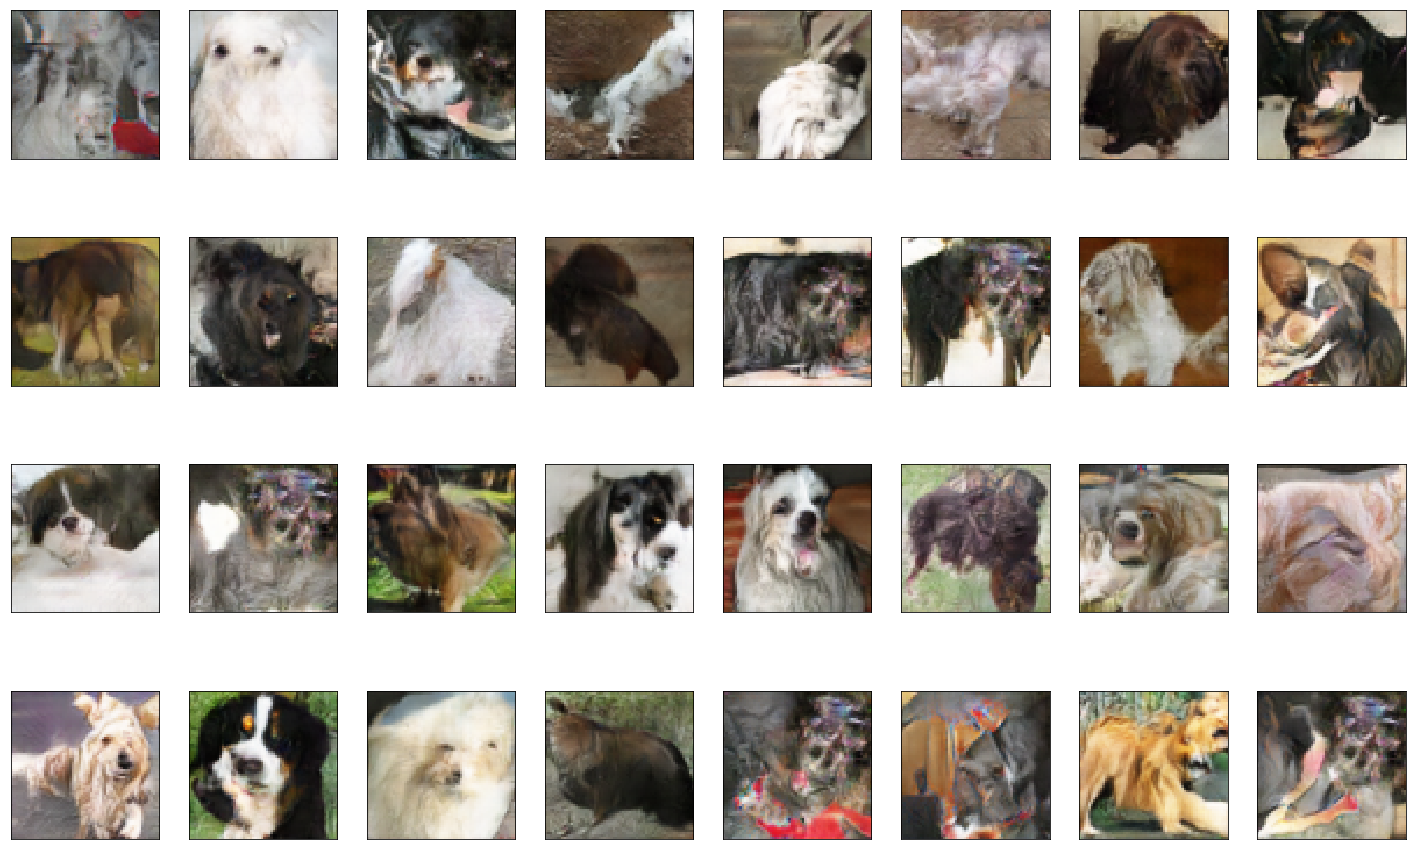

In [12]:
show_generated_img_all()